In [3]:
from sklearn.cluster import SpectralClustering as sc
import numpy.random as rand
from numpy.linalg import norm as dist
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from functools import partial
from scipy.special import expit
from sklearn.linear_model import Ridge as ridge
from sklearn.linear_model import Lasso as lasso
from sklearn.linear_model import LinearRegression as ols
from sklearn.svm import SVR as kernel_svr
from sklearn.svm import LinearSVR as lin_svr

from sklearn.kernel_ridge import KernelRidge as kernel_ridge


from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.tree import DecisionTreeRegressor as reg_tree
from sklearn.ensemble import AdaBoostRegressor as ada_reg
from sklearn.ensemble import GradientBoostingRegressor as gbr
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import copy

import statsmodels.api as sm
import statsmodels.formula.api as smf


import pandas as pd
import matplotlib

In [4]:
m = 1000
d = 1

In [5]:
T = rand.randint(0,2,(m,))
# T = T.ravel()
T.shape

(1000,)

In [6]:
mu_0 = 0
mu_1 = 0
nu_0 = -0.25
nu_1 = +0.25
kappa = 0.50

In [7]:
alpha = [1,2]
beta = [1,2]
gamma = [0.5,0.75]

ft = lambda t,x : alpha[t] + beta[t]*x + gamma[t]*x*x

In [8]:
mean = [[mu_0, nu_0],[mu_1, nu_1]]
cov = (2*T-1)*kappa
X, U = np.zeros(cov.shape), np.zeros(cov.shape[0])
for i in range(T.shape[0]):
    # int(cov[i])
    X[i], U[i] = np.random.multivariate_normal(mean[T[i]], [[1, cov[i]],[cov[i],1]]).T
print(X.shape,U.shape,cov.shape)

(1000,) (1000,) (1000,)


In [9]:
Y = np.vectorize(ft)(T,X) + U + 0.5* np.random.normal(size=U.shape)
Y.shape

(1000,)

In [10]:
X_E = np.random.uniform(-1,1, size=(m,))
U_E = np.random.normal(0,1, size=(m,))
T_E = rand.randint(0,2,(m,))
Y_E = np.vectorize(ft)(T_E, X_E) + U_E + 0.5* np.random.normal(size=U_E.shape)
print(X_E.shape, U_E.shape, T_E.shape, Y_E.shape)

(1000,) (1000,) (1000,) (1000,)


In [11]:
from lin_eta_gaussianU import generate_data_with_linear_eta

In [12]:
regs = [rfr(n_estimators=i) for i in [10, 20, 40, 60, 100, 150, 200]]
regs += [reg_tree(max_depth=i) for i in [5, 10, 20, 30, 40, 50]]
regs += [ada_reg(n_estimators=i) for i in [10, 20, 50, 70, 100, 150, 200]]
regs += [gbr(n_estimators=i) for i in [50, 70, 100, 150, 200]]

In [13]:
def get_best_for_data(X, Y, regs):
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2) # doesn't change X
    val_errs = []
    models = []
    for reg in regs:
        model = copy.deepcopy(reg)
        model.fit(x_train, y_train)
        val_errs.append(mse(y_test, model.predict(x_test)))
        models.append(copy.deepcopy(model))
    min_ind = val_errs.index(min(val_errs))
    print(str(model)[:40], val_errs[min_ind])
    return copy.deepcopy(models[min_ind])
    

In [14]:
f1pred_exp = get_best_for_data(X_E[T_E>0].reshape(-1,1), Y_E[T_E>0], regs)
f0pred_exp = get_best_for_data(X_E[T_E==0].reshape(-1,1), Y_E[T_E==0], regs)
f1pred_obs = get_best_for_data(X[T>0].reshape(-1,1), Y[T>0], regs)
f0pred_obs = get_best_for_data(X[T==0].reshape(-1,1), Y[T==0], regs)

# f0pred_exp.fit(X[T==0].reshape(-1, 1),Y[T==0])
# f1pred_obs.fit(X_E[T_E>0].reshape(-1, 1),Y_E[T_E>0])
# f0pred_obs.fit(X_E[T_E==0].reshape(-1, 1),Y_E[T_E==0])

GradientBoostingRegressor(alpha=0.9, cri 1.452023124136488
GradientBoostingRegressor(alpha=0.9, cri 1.1836337747786088
GradientBoostingRegressor(alpha=0.9, cri 1.2121514139756746
GradientBoostingRegressor(alpha=0.9, cri 1.1917623515273341


In [15]:
X_full = np.hstack((X, X_E))
print(X_full.shape)
Y_full = np.hstack((Y, Y_E))
print(Y_full.shape)
T_full = np.hstack((T, T_E))
neg_T = 2*T-1
neg_T_full = 2*T_full -1
exp_filter = np.array([False]*int(X_full.shape[0]/2) + [True]*int(X_full.shape[0]/2) )
print(exp_filter.shape)

(2000,)
(2000,)
(2000,)


In [16]:
omega = f1pred_obs.predict(X_E.reshape(-1,1)) - f0pred_obs.predict(X_E.reshape(-1,1)) 
tau = f1pred_exp.predict(X_E.reshape(-1,1)) - f0pred_exp.predict(X_E.reshape(-1,1))
print(omega.shape, tau.shape)

(1000,) (1000,)


In [17]:
omega_O = f1pred_obs.predict(X.reshape(-1,1)) - f0pred_obs.predict(X.reshape(-1,1)) 
tau_O = f1pred_exp.predict(X.reshape(-1,1)) - f0pred_exp.predict(X.reshape(-1,1))
print(omega.shape, tau.shape)

(1000,) (1000,)


In [18]:
eta_est = tau - omega
print(eta_est.shape)
eta_est_O = tau_O - omega_O
print(eta_est_O.shape)

(1000,)
(1000,)


In [19]:
# eta_ridge= ridge()
eta_ridge = get_best_for_data(X_E.reshape(-1, 1), eta_est, [ridge(alpha=a) for a in [1e-10]])# , 1e-5, 1e-4]])# ,1e-2,1,1e+2,1e+4, 1e+5]])
print(mse(eta_est, eta_ridge.predict(X_E.reshape(-1, 1))))
# print(mse(eta, -6*kappa*X_full))

Ridge(alpha=1e-10, copy_X=True, fit_inte 0.26188952449459757
0.2545489347980597


In [20]:
mu_T_full = np.array([mean[t][0] for t in T_full]).ravel()
nu_T_full = np.array([mean[t][1] for t in T_full]).ravel()
print(mu_T_full.shape, nu_T_full.shape)

(2000,) (2000,)


In [21]:
print(eta_ridge.coef_, eta_ridge.intercept_)
lambda_1 = nu_1 - kappa*mu_1
lambda_0 = nu_0 + kappa*mu_0

print(-2*kappa, -lambda_1 + lambda_0)

[-0.78630038] -0.6587794452214858
-1.0 -0.5


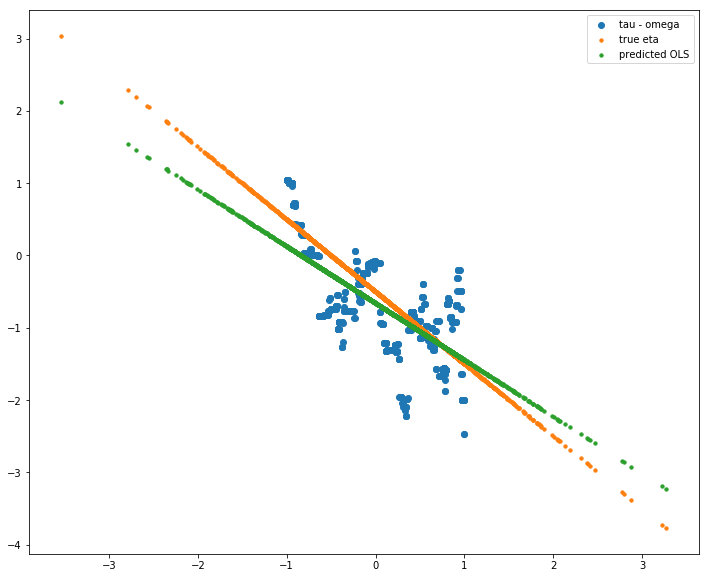

In [22]:
plt.figure(figsize=(12,10))
plt.scatter(X_E, eta_est, label='tau - omega')
plt.scatter(X_full, -2*kappa*X_full + - lambda_1 + lambda_0, label='true eta', s=11)
plt.scatter(X_full, eta_ridge.predict(X_full.reshape(-1, 1)), label='predicted OLS', s=11)
plt.legend()
plt.show()

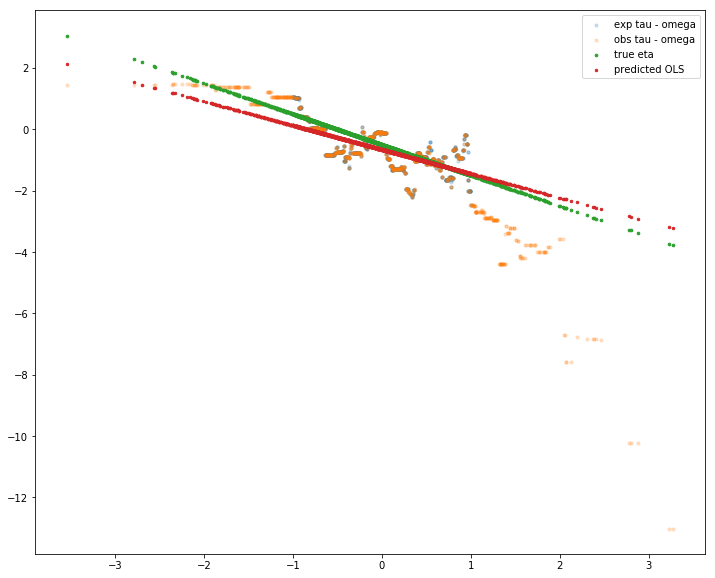

In [24]:
plt.figure(figsize=(12,10))
plt.scatter(X_E,
            eta_est,
            label='exp tau - omega',
            alpha=0.2, s =10)
plt.scatter(X,
            eta_est_O,
            label='obs tau - omega',
            alpha=0.2, s =10)
plt.scatter(X_full, -2*kappa*X_full -lambda_1 + lambda_0, label='true eta', s=7)
plt.scatter(X_full, eta_ridge.predict(X_full.reshape(-1, 1)), label='predicted OLS', s=6)
plt.legend()
plt.show()

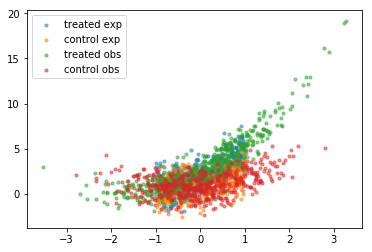

In [25]:
plt.scatter(X_E[T_E>0].reshape(-1,1), Y_E[T_E>0], label='treated exp', s=10, alpha=0.5)
plt.scatter(X_E[T_E==0].reshape(-1,1), Y_E[T_E==0], label='control exp', s=10, alpha=0.5)
plt.scatter(X[T>0].reshape(-1,1), Y[T>0], label='treated obs', s=10, alpha=0.5)
plt.scatter(X[T==0].reshape(-1,1), Y[T==0], label='control obs', s=10, alpha=0.5)
plt.legend()
plt.show()

In [26]:
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri as np2ri

robjects.numpy2ri.activate()

from rpy2.robjects.packages import importr
grf = importr('grf')
cf = grf.causal_forest

In [27]:
linear_regs = [ols()] 
linear_regs.extend([lasso(alpha=alph) for alph in [1e-5,1e-3,1e-1,1,1e+1,1e+3,1e+5]])
linear_regs.extend([ridge(alpha=alph) for alph in [1e-5,1e-3,1e-1,1,1e+1,1e+3,1e+5]])
# linear_regs.extend([kernel_ridge(alpha=alph, kernel=kern) for alph in [1e-5,1e-3,1e-1,1,1e+1,1e+3,1e+5] for kern in ['poly','rbf','sigmoid']])
# linear_regs.extend([lin_svr(C=c) for c in [1e-5,1e-3,1e-1,1,1e+1,1e+3,1e+5]])
# linear_regs.extend([kernel_svr(C=c) for c in [1e-5,1e-3,1e-1,1,1e+1,1e+3,1e+5] for kern in ['poly','rbf','sigmoid']])

In [28]:
def run_method(X_rct, Y_rct, T_rct, X_obs, Y_obs, T_obs):
    assert(X_rct.shape[0] == Y_rct.shape[0])
    assert(T_rct.shape[0] == Y_rct.shape[0])
    assert(X_obs.shape[0] == Y_obs.shape[0])
    assert(T_obs.shape[0] == Y_obs.shape[0])
    _cf_model = cf(X_obs.reshape(-1,1), Y_obs.reshape(-1,1), T_obs.astype(np.int).reshape(-1,1), num_trees=200)
    omega_rct_pred = np.array(grf.predict_causal_forest(_cf_model,  X_rct.reshape(-1,1))[0]).ravel()
    cate_rct_est = 2*np.multiply(Y_rct, 2*T_rct-1).ravel()
    # omega  and cate_rct_est should both have a shape (n_rct,)
    assert(cate_rct_est.shape == omega_rct_pred.shape)
    print(np.std(2*Y_rct)**2, np.std(cate_rct_est)**2, np.std(omega_rct_pred)**2)
    eta_est = cate_rct_est - omega_rct_pred
    assert(len(eta_est.shape) == 1)
    
    best_eta_est_linear = get_best_for_data(X_rct.reshape(-1,1), eta_est,  regs=linear_regs)
    omega_obs_pred = np.array(grf.predict_causal_forest(_cf_model,  X_obs)[0]).ravel()
    
    return copy.deepcopy(best_eta_est_linear), eta_est, omega_obs_pred

In [29]:
np.std(2*np.multiply(Y_E, 2*T_E-1).ravel()), np.std(Y_E)

(4.468305280787164, 1.5763339168982213)

In [30]:
[np.all(np.isfinite(item)) for item in [X_E, Y_E, T_E, X, Y, T]]

[True, True, True, True, True, True]

In [31]:
best_eta_reg , eta_est_cf, omega_obs_pred = run_method(X_E, Y_E, T_E, X, Y, T)

9.939314470254754 19.96575208231046 1.305094408131449
Ridge(alpha=100000.0, copy_X=True, fit_i 18.916202025450424


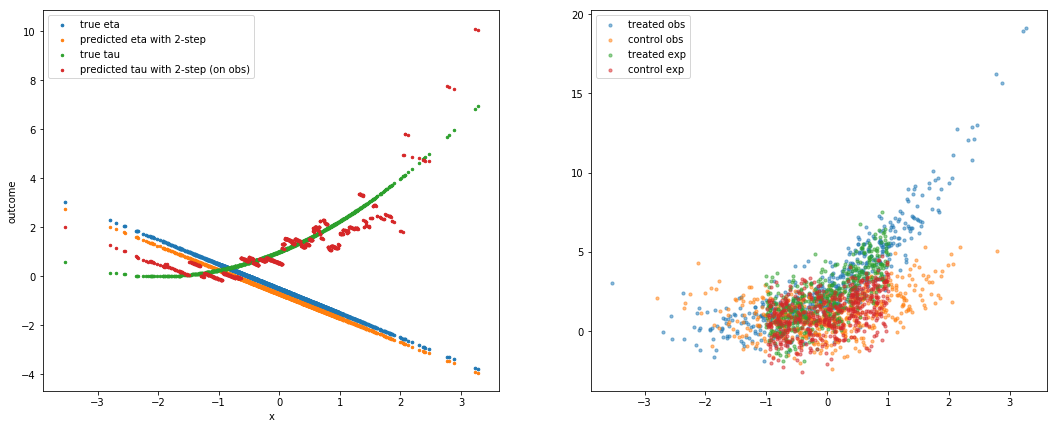

In [32]:
# plt.figure(figsize=(12,7))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,7))
# ax1.scatter(X_E,
#             eta_est,
#             label='exp tau - omega',
#             alpha=0.4, s =10)
# ax1.scatter(X,
#             eta_est_O,
#             label='obs tau - omega',
#             alpha=0.4, s =10)
ax1.scatter(X_full, -2*kappa*X_full -lambda_1 + lambda_0, label='true eta', s=7)
# ax1.scatter(X_full, eta_ridge.predict(X_full.reshape(-1, 1)), label='predicted eta with OLS', s=6)
ax1.scatter(X_full, best_eta_reg.predict(X_full.reshape(-1, 1)), label='predicted eta with 2-step', s=6)
ax1.scatter(X, np.vectorize(ft)(np.ones(X.shape[0]).astype(np.int),X) - np.vectorize(ft)(np.zeros(X.shape[0]).astype(np.int),X), label='true tau', s=6)
ax1.scatter(X, omega_O + best_eta_reg.predict(X.reshape(-1, 1)), label='predicted tau with 2-step (on obs)', s=6)

ax1.set_xlabel('x')
ax1.set_ylabel('outcome')

# ax1.set_title('mu_1={},mu_0={}, nu_0={}, nu_1={}, kappa={}'.format(mu_1, mu_0, nu_0, nu_1, kappa))
ax1.legend()


ax2.scatter(X[T>0].reshape(-1,1), Y[T>0], label='treated obs', s=10, alpha=0.5)
ax2.scatter(X[T==0].reshape(-1,1), Y[T==0], label='control obs', s=10, alpha=0.5)
ax2.scatter(X_E[T_E>0].reshape(-1,1), Y_E[T_E>0], label='treated exp', s=10, alpha=0.5)
ax2.scatter(X_E[T_E==0].reshape(-1,1), Y_E[T_E==0], label='control exp', s=10, alpha=0.5)
ax2.legend()
plt.show()

In [33]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')

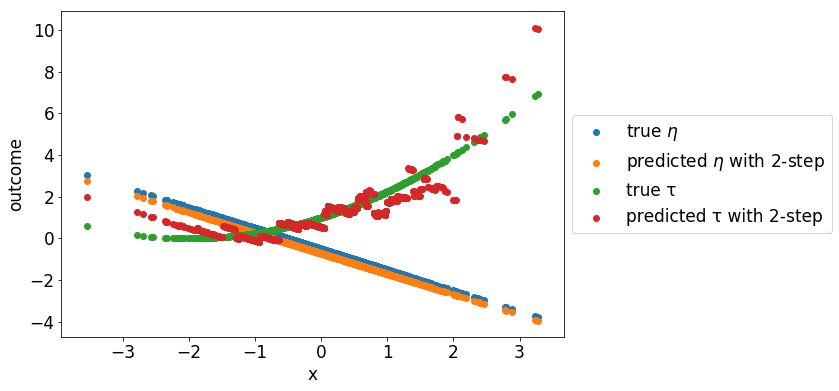

In [34]:
font = { # 'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 17}

matplotlib.rc('font', **font) 
f,ax1 = plt.subplots(1, 1, figsize=(9,6))
# ax1.scatter(X_E,
#             eta_est,
#             label='exp tau - omega',
#             alpha=0.4, s =10)
# ax1.scatter(X,
#             eta_est_O,
#             label='obs tau - omega',
#             alpha=0.4, s =10)
ax1.scatter(X_full, -2*kappa*X_full -lambda_1 + lambda_0, label='true $\eta$')# , s=7)
# ax1.scatter(X_full, eta_ridge.predict(X_full.reshape(-1, 1)), label='predicted $\eta$ with OLS')#, s=6)
ax1.scatter(X_full, best_eta_reg.predict(X_full.reshape(-1, 1)), label='predicted $\eta$ with 2-step')# , s=6)
ax1.scatter(X, np.vectorize(ft)(np.ones(X.shape[0]).astype(np.int),X) - np.vectorize(ft)(np.zeros(X.shape[0]).astype(np.int),X), label='true τ')#, s=6)
ax1.scatter(X, omega_O + best_eta_reg.predict(X.reshape(-1, 1)), label='predicted τ with 2-step')#, s=6)
plt.xlabel('x', fontsize=17)
plt.ylabel('outcome',  fontsize=17)
# ax1.set_title('mu_1={},mu_0={}, nu_0={}, nu_1={}, kappa={}'.format(mu_1, mu_0, nu_0, nu_1, kappa))
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


In [47]:
x_to_plot = np.arange(-3,3,0.01)

In [48]:
_cf_model = cf(X_E.reshape(-1,1), Y_E.reshape(-1,1), T_E.astype(np.int).reshape(-1,1), num_trees=500)
omega_obs_pred = np.array(grf.predict_causal_forest(_cf_model,  X.reshape(-1,1))[0]).ravel()
omega_obs_pred_to_plot = np.array(grf.predict_causal_forest(_cf_model,  x_to_plot.reshape(-1,1))[0]).ravel()

In [49]:
omega_O_to_plot = f1pred_obs.predict(x_to_plot.reshape(-1,1)) - f0pred_obs.predict(x_to_plot.reshape(-1,1)) 
tau_O_to_plot = f1pred_exp.predict(x_to_plot.reshape(-1,1)) - f0pred_exp.predict(x_to_plot.reshape(-1,1))

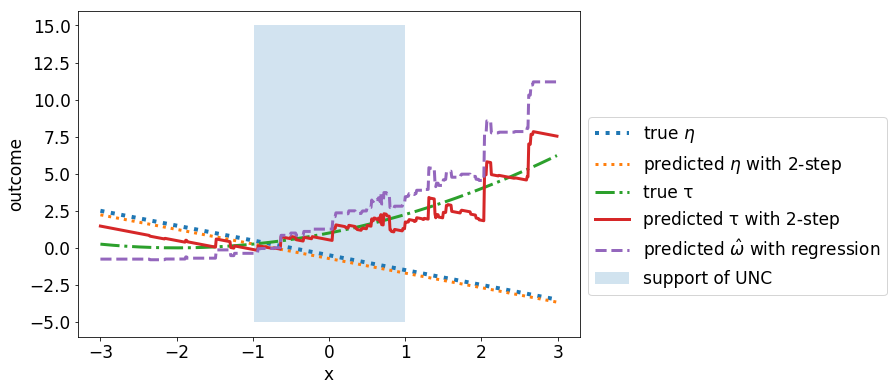

In [69]:
font = { # 'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 17}

matplotlib.rc('font', **font) 
f,ax1 = plt.subplots(1, 1, figsize=(9,6))
# ax1.scatter(X_E,
#             eta_est,
#             label='exp tau - omega',
#             alpha=0.4, s =10)
# ax1.scatter(X,
#             eta_est_O,
#             label='obs tau - omega',
#             alpha=0.4, s =10)
ax1.plot(x_to_plot, -2*kappa*x_to_plot -lambda_1 + lambda_0, label='true $\eta$', linewidth=4, linestyle=':')# , s=7)
ax1.plot(x_to_plot, best_eta_reg.predict(x_to_plot.reshape(-1, 1)), label='predicted $\eta$ with 2-step', linewidth=3, linestyle=':')# , s=7)# , s=6)
ax1.plot(x_to_plot, np.vectorize(ft)(np.ones(x_to_plot.shape[0]).astype(np.int),x_to_plot) - np.vectorize(ft)(np.zeros(x_to_plot.shape[0]).astype(np.int),x_to_plot), label='true τ', linewidth=3, linestyle='-.')
ax1.plot(x_to_plot, omega_O_to_plot + best_eta_reg.predict(x_to_plot.reshape(-1, 1)), label='predicted τ with 2-step', linewidth=3, linestyle='-')# , s=7)
ax1.plot(x_to_plot, omega_O_to_plot, label='predicted $\hat{\omega}$ with regression', linewidth=3, linestyle='--')# , s=7)
ax1.fill_between(x_to_plot, -5, 15, where=np.abs(x_to_plot)<1,label='support of UNC', alpha=0.2)
plt.xlabel('x', fontsize=17)
plt.ylabel('outcome',  fontsize=17)
# ax1.set_title('mu_1={},mu_0={}, nu_0={}, nu_1={}, kappa={}'.format(mu_1, mu_0, nu_0, nu_1, kappa))
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.4))
plt.show()
